In [529]:
# Determine if Stacking Players can give you an edge in best ball

import pandas as pd
import os
import numpy as np
import requests
from requests.auth import HTTPBasicAuth
from difflib import SequenceMatcher
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

base_dir = os.path.dirname(os.path.abspath(""))
data_dir = os.path.join(base_dir, "data/underdog_adp_2022/regular_season")

# Set Plotting Styles
font_path = "./assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("assets/stylesheets/fdp_base.mplstyle")

# Read in regular season draft data. This will take several seconds since the files are large
print('Loading Best Ball Regular Season Draft Dump...')
frames=[]
for file in os.listdir(f'{data_dir}):
    print(f'Loading {file}')
    df=pd.read_csv(f'{data_dir}/{file}')
    frames.append(df)

df=pd.concat(frames)



Loading Best Ball Regular Season Draft Dump...


In [530]:
# Get Week 1 2022 roster data so we can merge team name into data frame.
# We'll tap the nfl data exchange to get the week 1 rosters

URL = f'https://www.nfl.info/nfldataexchange/dataexchange.asmx/getRosterAll?lseason=2022&lweek=1&lseasontype=REG&lclub=ALL&showall=True'
response = requests.get(URL, auth=HTTPBasicAuth("media", "media")).content

print('Retrieving 2022 Week 1 Roster Data from NFL Data Exchange...')
rosters = pd.read_xml(response)

# Filter roster to positional players only
rosters = rosters[rosters.Position.isin(['QB','RB','FB','WR','TE'])]

# Rename team column in rosters data frame
rosters.rename(
    {
        'CurrentClub':'team'
    },
    axis=1,
    inplace=True
)

# Create column for player name
rosters['player_name'] = rosters.FootballName+' '+rosters.LastName

# Remove duplicate player names
rosters = rosters.groupby('player_name').first().reset_index()

# Get list of players in rosters data frame
roster_df_players = rosters.player_name.unique()

# Get list of players in main data frame
main_df_players = df.player_name.unique()

# Merge team column into main data frame
df = df.merge(rosters[['player_name','team']],on='player_name',how='left')

# Any player mismatches (i.e. DK Metcalf vs D.K. Metcalf) 
# will have null team columns. Use this to get list of player mismatches
mismatches = df[df.team.isna()==True].player_name.unique()

# Repair player mismatches by finding potential matches using SequenceMatcher
rematch_dict={}
for mismatch in mismatches:
    idx=np.argmax(
        [
            SequenceMatcher(
                None, mismatch, potential_match
            ).ratio()for potential_match in roster_df_players
        ])
    max_seq=np.max(
        [
            SequenceMatcher(
                None, mismatch, potential_match
            ).ratio()for potential_match in roster_df_players
        ])
    
    # After manually checking, most ratios <0.85 fail to find the right player
    # If max_seq >=0.85, add player mismatch names to dict (ex: {'Robby Anderson':'Robbie Anderson'})
    if max_seq>=0.85:
        rematch_dict[roster_df_players[idx]]=mismatch

# Replace roster data frame names with new names from rematch_dict
rosters.loc[
    rosters.player_name.isin(rematch_dict.keys()),'player_name'
]=rosters.loc[
    rosters.player_name.isin(rematch_dict.keys()),'player_name'
].apply(lambda x: rematch_dict[x])

# Drop team column from master data frame and remerge with rosters data frame
df.drop('team',axis=1,inplace=True)
df=df.merge(rosters[['team','player_name']],on='player_name',how='left')

# Most of the remaining mismatches are unrostered players (Antonio Brown, Gronk, Odell, etc.)
# Manually add team names in for any remaining player mismatches
# Most remaining mismatches are players who were free agents/practice squad week 1 and
# were later added to the active roster or signed by a team
df.loc[df.player_name=='Jalen Hurts','team']='PHI'
df.loc[df.player_name=='Dee Eskridge','team']='SEA'
df.loc[df.player_name=='PJ Walker','team']='CAR'
df.loc[df.player_name=='Tevin Coleman','team']='SF'
df.loc[df.player_name=='DeSean Jackson','team']='BAL'
df.loc[df.player_name=='Phillip Lindsay','team']='IND'
df.loc[df.player_name=='Malik Willis','team']='TEN'
df.loc[df.player_name=='Jordan Wilkins','team']='IND'
df.loc[df.player_name=='Michael Woods','team']='CLE'
df.loc[df.player_name=='Duke Johnson','team']='BUF'
df.loc[df.player_name=='Kylin Hill','team']='GB'

Retrieving 2022 Week 1 Roster Data from NFL Data Exchange...


In [531]:
# We now have the team associated with each player in our main data frame and can finally
# get to some analysis

# Lets determine the maximum number of correlated players on reach BB roster
# To start we'll assume any player on the same team is correlated

# Groupy by draft entry id and team to get the number of players from each
# team on each roster, then groupby draft_entry_id and take the max number of correlated 
# players on each Best Ball roster

max_correlated_players=df.groupby(
    ['draft_entry_id','team']
).size().groupby('draft_entry_id').max()

# Give the series we just created a name before we join it to the main data frame
max_correlated_players.name='maxCorrPlayers'

# Join max_correlated_players series with data frame
df=df.set_index('draft_entry_id').join(max_correlated_players)



/var/folders/wv/kpqdy9wd2y7d3vr7fg4q7_g80000gn/T/ipykernel_4067/3295790750.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('maxCorrPlayers').mean()['roster_points'].plot(


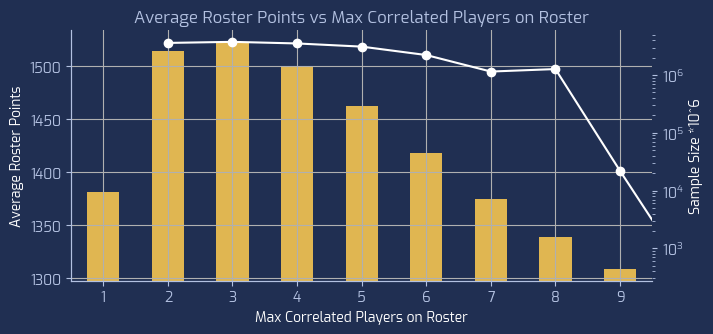

In [532]:
# Lets simply group our data frame by maxCorrPlayers and see how roster scores
# behave as a function of the maximum number of players from one team on a Best Ball Roster

# Plot Line Graph of Average Roster Points vs Max Correlated Players on Roster
fig,ax = plt.subplots()

df.groupby('maxCorrPlayers').mean()['roster_points'].plot(
    color='white',marker='o',ax=ax
)
ax.set_ylabel('Average Roster Points')
ax.set_xlabel('Max Correlated Players on Roster')
ax.set_title('Average Roster Points vs Max Correlated Players on Roster')
ax.set_zorder(1)
ax.patch.set_visible(False)

# Plot a bar graph of the sample size of each group
ax2 = ax.twinx()
# Large spread among sample sizes so use a logarithmic scale
ax2.set_yscale('log')
df.groupby('maxCorrPlayers').size().plot.bar(color='#E0B651',ax=ax2)
ax2.set_ylabel('Sample Size *10^6')
ax2.grid(False)




/var/folders/wv/kpqdy9wd2y7d3vr7fg4q7_g80000gn/T/ipykernel_4067/1864108680.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('maxCorrPlayers').mean()['roster_points'].plot(


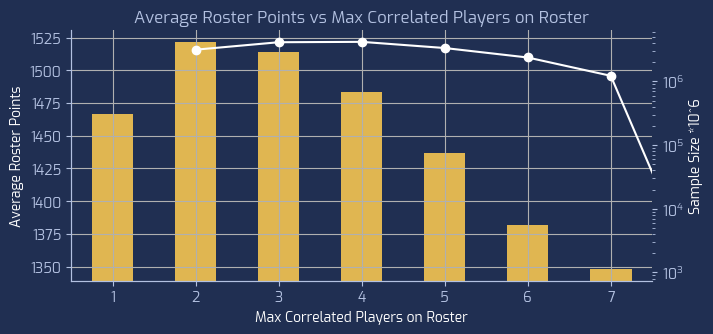

In [533]:
# From the plot above, if we simply look at max number of players from the same team on
# a roster, the relationship is generally inverse, meaning the more players a roster
# has from the same team, the fewer points a roster scored on average. We're also assuming that
# every player from the same team is correlated which isn't really true. 
#Lets see if we can do better by making a fair assumptoin that running backs are not correlated. 
# Of course there are exceptions to this (CMC!), but for this expriment we will only count
# QB,WR, and TE as correlated players

# Start by dropping max_correlated_players column from main data frame before we add new one
df.drop('maxCorrPlayers',
        axis=1,
        inplace=True,
       errors='ignore')

# Calculate max number of correlated players on a roster including only QB,WR,TE
max_correlated_players=df[
    df.position_name.isin(['QB','WR','TE'])
].groupby(
    ['draft_entry_id','team']
).size().groupby('draft_entry_id').max()

# Give the series we just created a name before we join it to main data frame
max_correlated_players.name='maxCorrPlayers'

# Join max_corr series with data frame
df=df.join(max_correlated_players)

# Plot New Line Graph of Average Roster Points vs Max Correlated Players on Roster
fig,ax=plt.subplots()
df.groupby('maxCorrPlayers').mean()['roster_points'].plot(
    color='white',marker='o',ax=ax
)
ax.set_ylabel('Average Roster Points')
ax.set_xlabel('Max Correlated Players on Roster')
ax.set_title('Average Roster Points vs Max Correlated Players on Roster')
ax.set_zorder(1)
ax.patch.set_visible(False)

df.groupby('maxCorrPlayers').size()

ax2 = ax.twinx()
# Large spread among sample sizes so use a logarithmic scale
ax2.set_yscale('log')
df.groupby('maxCorrPlayers').size().plot.bar(color='#E0B651',zorder=0,ax=ax2)
ax2.set_ylabel('Sample Size *10^6')
ax2.grid(False)



In [534]:
# We see that if we exclude RBs from our correlated players that the average score
# per roster as a function of number of correlated players is a bit higher when a roster
# contains 2 or 3 players from the same team, but not substantially. We see a sharp drop off
# in average points per roster once the number of correlated players on a roster gets to 7.
# We can still do better though, not all QBs and their receivers correlate well. Some correlate
# much better than others. We can see how players on the same team correlate with each other
# or more importantly with their QB, by creating a correlation matrix. The matrix will have columns for 
# ppr points scored for QB, RB1,RB2, WR1,WR2,WR3 and TE1. We can then see how Best Ball roster
# scores behave as a function of number of players that correlate well with their QB 
# This is only valid for rosters with QB/Receier Stacks



# First we need to determine each players depth position from last season (2021)
# To achieve this we can determine where each player finished in scoring on their team 
# With respect to each position, i.e who was WR1,2,3 etc
# Since we want this information prior to a draft, lets grab data from the 2021 season

ff_data = nfl.import_weekly_data([2021])

# Rename team column
ff_data.rename({'recent_team':'team'},axis=1,inplace=True)

# Get Positional Rank for each player by team
ff_data['pos_rank'] = ff_data.groupby(
    ['team','week','position']
).fantasy_points_ppr.rank(ascending=False)

# Create PPR data frames for each position ranking so we can create a correlation matrix

# Get QB1 Data
qb1 = ff_data[
    (ff_data.position=='QB')&
    (ff_data.pos_rank==1)
].rename({'recent_team':'team'},axis=1).set_index(
    ['team','week'])[['fantasy_points_ppr']].add_prefix('QB_')

# Get RB1 Data
rb1 = ff_data[
    (ff_data.position=='RB')&
    (ff_data.pos_rank==1)
].rename({'recent_team':'team'},axis=1).set_index(
    ['team','week'])[['fantasy_points_ppr']].add_prefix('RB1_')

# Get RB2 Data
rb2 = ff_data[
    (ff_data.position=='RB')&
    (ff_data.pos_rank==2)
].rename({'recent_team':'team'},axis=1).set_index(
    ['team','week'])[['fantasy_points_ppr']].add_prefix('RB2_')

# Get WR1 Data
wr1 = ff_data[
    (ff_data.position=='WR')&
    (ff_data.pos_rank==1)
].rename({'recent_team':'team'},axis=1).set_index(
    ['team','week'])[['fantasy_points_ppr']].add_prefix('WR1_')
# Get WR2 Data
wr2 = ff_data[
    (ff_data.position=='WR')&
    (ff_data.pos_rank==2)
].rename({'recent_team':'team'},axis=1).set_index(
    ['team','week'])[['fantasy_points_ppr']].add_prefix('WR2_')
# Get WR3 Data
wr3 = ff_data[
    (ff_data.position=='WR')&
    (ff_data.pos_rank==3)
].rename({'recent_team':'team'},axis=1).set_index(
    ['team','week'])[['fantasy_points_ppr']].add_prefix('WR3_')
# Get TE1 Data
te1 = ff_data[
    (ff_data.position=='TE')&
    (ff_data.pos_rank==1)
].rename({'recent_team':'team'},axis=1).set_index(
    ['team','week'])[['fantasy_points_ppr']].add_prefix('TE1_')

Downcasting floats.


In [535]:
# Join our PPR DataFrames to our ff_data frame and create a matrix variable
ff_data.set_index(['team','week'],inplace=True)
ff_data=ff_data.join(qb1).join(rb1).join(rb2).join(wr1).join(wr2).join(wr3).join(te1)

# Create Matrix Variable
matrix = ff_data[['QB_fantasy_points_ppr',
 'RB1_fantasy_points_ppr',
 'RB2_fantasy_points_ppr',
 'WR1_fantasy_points_ppr',
 'WR2_fantasy_points_ppr',
 'WR3_fantasy_points_ppr',
 'TE1_fantasy_points_ppr']]

# Join process resulted in duplicate rows, use the first() function to drop the duplicates
# Could also use .drop_duplicates() function
matrix=matrix.groupby(['team','week']).first()

# Create Correlation Matrix
matrix=matrix.groupby('team').corr().reset_index()

# Filter Matrix so that we only have correlations between QB and Positional Players
matrix = matrix[matrix.level_1=='QB_fantasy_points_ppr']

# Drop column we no longer need and at _corr as a suffix to each column
matrix=matrix.set_index('team').drop('level_1',axis=1).add_suffix('_corr')

# Merge each team position/QB Correlation to main data frame
df=df.merge(matrix,on='team',how='left')



In [536]:
# If we're planning on stacking our roster with QB/position combos that we know are
# correlated, we want an idea of who the WR1,2,3 TE1 might be on each team on draft day
# We'll use each players projection_adp to assign their implied positional ranking for the team they're on

# Groupby team,player name and apply first function to get each unique player in the main data frame
# then groupby team and position to get each players positional rank for their respective team
implied_pos_rankings=df.groupby(
    ['team','player_name']
).first().groupby(
    ['team','position_name']
)[['projection_adp']].rank(
    method='first'
).rename({'projection_adp':'proj_pos_rank'},axis=1)

# Merge Implied Team Position Rankings to main data frame
df=df.merge(implied_pos_rankings,on=['team','player_name'],how='left')

# Create column for implied player correlation to QB ("implied_qb_corr")
# and fill accordingly with correlation matrix columns we merged in previously for each team

df.loc[(df.position_name=='RB')&
      (df.proj_pos_rank==1),'implied_qb_corr']=df.loc[(df.position_name=='RB')&
      (df.proj_pos_rank==1),'RB1_fantasy_points_ppr_corr']

df.loc[(df.position_name=='RB')&
      (df.proj_pos_rank==2),'implied_qb_corr']=df.loc[(df.position_name=='RB')&
      (df.proj_pos_rank==2),'RB2_fantasy_points_ppr_corr']

df.loc[(df.position_name=='WR')&
      (df.proj_pos_rank==2),'implied_qb_corr']=df.loc[(df.position_name=='WR')&
      (df.proj_pos_rank==2),'WR2_fantasy_points_ppr_corr']

df.loc[(df.position_name=='WR')&
      (df.proj_pos_rank==3),'implied_qb_corr']=df.loc[(df.position_name=='WR')&
      (df.proj_pos_rank==3),'WR3_fantasy_points_ppr_corr']

df.loc[(df.position_name=='TE')&
      (df.proj_pos_rank==1),'implied_qb_corr']=df.loc[(df.position_name=='WR')&
      (df.proj_pos_rank==1),'WR1_fantasy_points_ppr_corr']

df.loc[(df.position_name=='TE')&
      (df.proj_pos_rank==1),'implied_qb_corr']=df.loc[(df.position_name=='TE')&
      (df.proj_pos_rank==1),'TE1_fantasy_points_ppr_corr']

In [537]:
# We need to create a column that tells us each BB rosters QB team to see if
# the implied qb correlation column is valid for that roster. If the players QB is not
# on the BB roster then their correlation to their quarterback is irrelvant when assessing 
# the relationship between that roster's points scored and correlated players

# Best ball rosters can have more than one quarterback, but for simplicity sake,
# let's only worry about each rosters top drafted quarterback. We'll sort our main
# data frame by team pick number so that when we group by each entry id and take the first
# quarterback, it will be the first QB drafted for that roster, or the expected QB1

df.sort_values(by='team_pick_number',inplace=True)
roster_qbs = df[df.position_name=='QB'].groupby('tournament_entry_id').first()[['team']].add_prefix('QB_')

# Add QB_team column to main data frame
df = df.merge(roster_qbs,on='tournament_entry_id',how='left')

# Since we want to know the effect of players who are correlated, we can null out players
# with negative correlation to their QBs as well as players from teams different than the BB roster QB1

df.loc[(df.team!=df.QB_team),'implied_qb_corr']=np.nan
df.loc[df.implied_qb_corr<0,'implied_qb_corr']=np.nan


In [538]:
# Instead of just seeing how many QB/receiver combos are on each roster
# Lets see how many players on reach roster correlate with their QB >0.10
df.loc[df.implied_qb_corr>0.1,'positive_corr']=1

# Determine how many correlated players each BB roster has
df['correlated_players'] = df.groupby('tournament_entry_id').positive_corr.transform(np.sum)

/var/folders/wv/kpqdy9wd2y7d3vr7fg4q7_g80000gn/T/ipykernel_4067/766657084.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('correlated_players').mean().roster_points.plot(ax=ax,color='#E0B651',marker='o')


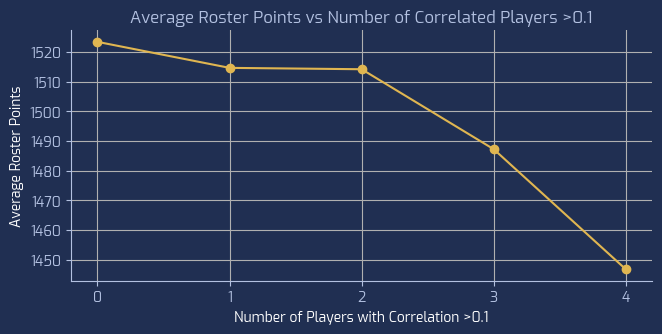

In [539]:
fig,ax=plt.subplots()
df.groupby('correlated_players').mean().roster_points.plot(ax=ax,color='#E0B651',marker='o')
ax.set_ylabel('Average Roster Points')
ax.set_xlabel('Number of Players with Correlation >0.1')
ax.set_title('Average Roster Points vs Number of Correlated Players >0.1')
ax.set_xticks([0,1,2,3,4])

In [540]:
# So even if we only consider players who correlate well with their quarterbacks, we see average
# Best Ball roster scores drop as the number of correlated players on the roster increases.
# This makes sense though because it's a high risk high reward strategy. You're only rewarded
# If you choose the top stacks, which is difficult. Only a handfull of rosters will achieve that
# Just for grins and giggles, lets look at rosters that drafted QBs projected to finish in the 
# Top 5

# Create a column that tells us whether or not a roster's QB1 was projected to be a top 5 QB
# We'll use ADP as our metric

QBRanks=df[
    (df.position_name=='QB')&(df.projection_adp!=0)
][['player_name','projection_adp']].groupby(
    'player_name'
).first()[['projection_adp']].rank().add_prefix('qb_')

df=df.merge(QBRanks,on='player_name',how='left')
df['qb_projection_adp']=df.groupby('tournament_entry_id').qb_projection_adp.transform(np.max)

#  Create a boolean (True or False) column that indicates whether or not a rosters QB was a projected Top5
#  Ignore adps with a value of 0
df.loc[(df.qb_projection_adp>0)&
      (df.qb_projection_adp<=5),'Top5QB']=1

df.Top5QB.fillna(0,inplace=True)

/var/folders/wv/kpqdy9wd2y7d3vr7fg4q7_g80000gn/T/ipykernel_4067/1316767357.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['Top5QB','correlated_players']).mean().roster_points.plot(marker='o',ax=ax,color='white')


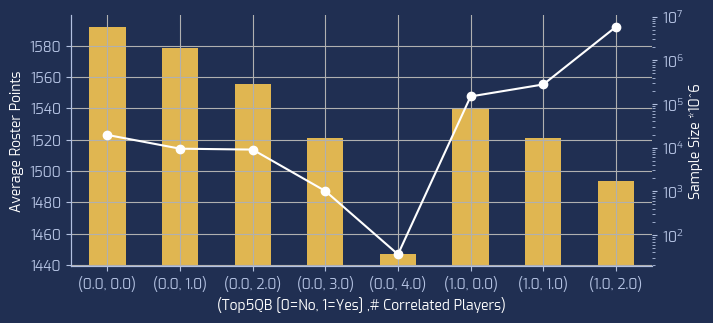

In [541]:
fig,ax = plt.subplots()

# Group data frame by rosters with/without Top5QBs and the number of correlated players they have with that QB
df.groupby(['Top5QB','correlated_players']).mean().roster_points.plot(marker='o',ax=ax,color='white')
ax.set_ylabel('Average Roster Points')
ax.set_xlabel('(Top5QB [0=No, 1=Yes] ,# Correlated Players)')
ax.set_zorder(1)
ax.patch.set_visible(False)

# Make a bar plot to show the sample size of each group
ax2 = ax.twinx()

# Large spread among sample sizes so use a logarithmic scale
ax2.set_yscale('log')

df.groupby(['Top5QB','correlated_players']).size().plot.bar(color='#E0B651',ax=ax2)
ax2.set_ylabel('Sample Size *10^6')
ax2.grid(False)

In [542]:
# And finally the signal we were looking for! Correlated rosters in best ball help
# But only if you have drafted a Top 5 Quarterback. We can also see from this plot that the
# Average roster score jumps substantially once we reach the side of the axis where rosters contain
# a Top5 QB, and furthermore, we continue to see the average roster score go up when 
# Top 5 QBs are stacked with players they correlated with at a value > 0.1

